Part Un: Setting up

First I import the data file and pandas to prepare the data frame. Can't do anything without a data frame ;)

In [73]:
import pandas as pd
import numpy as np
df = pd.read_csv('automobile.csv')
df=df.replace('?',np.nan).replace(r'^\s*$',np.nan, regex = True)

Before I perform the train-test split I would like to drop the 'symboling' (insurance riskiness) and 'normalized-losses' (average insurance payout thingy? Idr) 

Additionally `city_mpg` and `highway_mpg` will be replaced with `avg_mpg` for effeciency.

In [74]:
df['city_mpg'] = (df['city_mpg']+df['highway_mpg'])/2
df.rename(columns={'city_mpg': "avg_mpg"}, inplace = True)
df = df.drop(['symboling','normalized_losses','highway_mpg'], axis = 1)
df.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,avg_mpg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,four,130,mpfi,3.47,2.68,9.0,111,5000,24.0,13495
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,four,130,mpfi,3.47,2.68,9.0,111,5000,24.0,16500
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,six,152,mpfi,2.68,3.47,9.0,154,5000,22.5,16500
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,four,109,mpfi,3.19,3.4,10.0,102,5500,27.0,13950
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,five,136,mpfi,3.19,3.4,8.0,115,5500,20.0,17450


Insurance data is determined after the purchase of a car, and I'm assuming I'm using this data to buy a new car (bad idea I know, never buy new, and never rent). Using those two columns would probably greatly improve my model but since I won't have this info available when I actually buy a car they would be a source of data leakage. 

There is another step I gotta take beofre splitting up the dataset: find and replace missing values.

First I find all the columns with missing values.

In [75]:
missing_vals = df.isna()
for column in df.columns[missing_vals.any()]:
        print(column)
        print (missing_vals[column].value_counts())

num_of_doors
False    201
True       1
Name: num_of_doors, dtype: int64
bore
False    198
True       4
Name: bore, dtype: int64
stroke
False    198
True       4
Name: stroke, dtype: int64
horsepower
False    200
True       2
Name: horsepower, dtype: int64
peak_rpm
False    200
True       2
Name: peak_rpm, dtype: int64


Force numerical categories into floats first:

In [76]:
df[["bore", "stroke","price","compression_ratio","horsepower", "peak_rpm"]] = df[[
    "bore", "stroke","price","compression_ratio","horsepower", "peak_rpm"]].astype("float")

In [77]:
df[["curb_weight", "engine_size","avg_mpg"]] = df[[
    "curb_weight", "engine_size","avg_mpg"]].astype("float")

There are five columns with missing entries, in which I employ two strategies to fill in missing vlaues. For the categorical variable `num_of_doors` I used the most frequent value ('four'), whereas for numerical variables `bore`, `stroke`, `horsepower`, and `peak_rpm` I used the mean.

In [78]:
df.num_of_doors = df.num_of_doors.fillna("four", inplace = False)
df.fillna({'bore': df.bore.mean(), 'stroke': df.stroke.mean(), 'peak_rpm': df.peak_rpm.mean()}, inplace = False)
df.horsepower = df.horsepower.fillna(df.horsepower.mean(), inplace = False)

Split the dataset into training and testing sets:

In [79]:
from sklearn.model_selection import train_test_split
y = df['price']
X = df.drop('price', axis = 1)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

The code below is just to check my train and test set sizes; I will play around with this until I get a satistfactory answer:

In [80]:
print("number of test samples :", test_X.shape[0])
print("number of training samples:",train_X.shape[0])

number of test samples : 51
number of training samples: 151


Since the non-test sample is fairly small, I feel very inclined to use cross-validation when I need to validate my model in the future. Right now I'm still figuring out how it works so this bit will be updated.

Part Deux: Picking good features

I'll start with the numeric categories first (cause linear regression is a hell of a lot easier than picking which of the 20 different graphs to fit on categorical data).


 Import necessary data visualization libraries & combine training data together:

In [81]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

For the below visualizations to work, I must combine my training datasets together:

In [82]:
train = pd.concat([train_X, train_y], axis = 1)
train.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,avg_mpg,price
124,porsche,gas,std,two,hardtop,rwd,rear,89.5,168.9,65.0,...,six,194.0,mpfi,3.74,2.90,9.5,207.0,5900.0,21.0,34028.0
185,volkswagen,gas,std,two,convertible,fwd,front,94.5,159.3,64.2,...,four,109.0,mpfi,3.19,3.40,8.5,90.0,5500.0,26.5,11595.0
97,nissan,gas,std,four,sedan,fwd,front,97.2,173.4,65.2,...,four,120.0,2bbl,3.33,3.47,8.5,97.0,5200.0,30.5,9549.0
149,toyota,gas,std,four,wagon,fwd,front,95.7,169.7,63.6,...,four,92.0,2bbl,3.05,3.03,9.0,62.0,4800.0,34.0,6918.0
24,dodge,gas,std,four,sedan,fwd,front,93.7,157.3,63.8,...,four,90.0,2bbl,2.97,3.23,9.4,68.0,5500.0,34.5,6692.0


1. Numerical variables

I would like to find which numerical variables are the most highly correlated with price.

In [83]:
def plot_vis(m):
    sns.set(rc = {'figure.figsize':(6,4)})
    sns.regplot(x = m, y = 'price', data = train)
    plt.ylim(0,)
    plt.title('correlation between '+ m +  ' and price')
    plt.show()
    print(df[[m,'price']].corr())

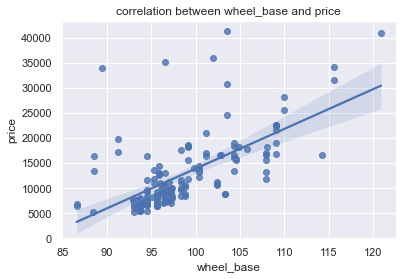

            wheel_base     price
wheel_base    1.000000  0.588382
price         0.588382  1.000000


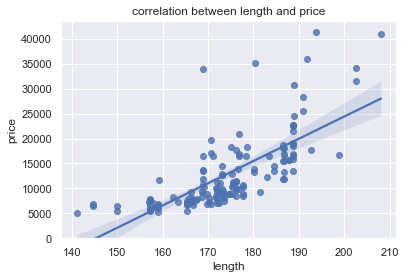

          length     price
length  1.000000  0.692774
price   0.692774  1.000000


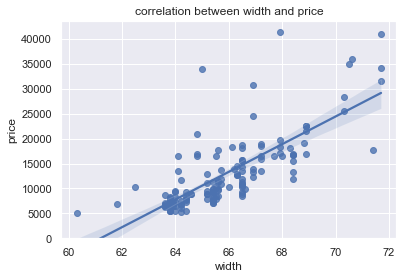

          width     price
width  1.000000  0.753236
price  0.753236  1.000000


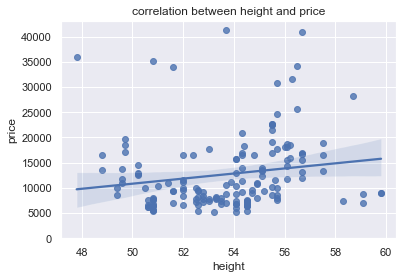

          height     price
height  1.000000  0.139003
price   0.139003  1.000000


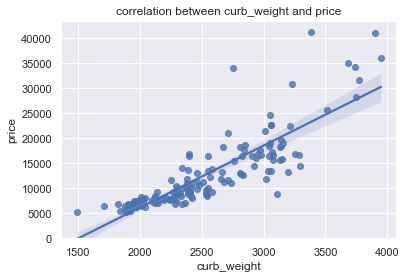

             curb_weight     price
curb_weight     1.000000  0.835277
price           0.835277  1.000000


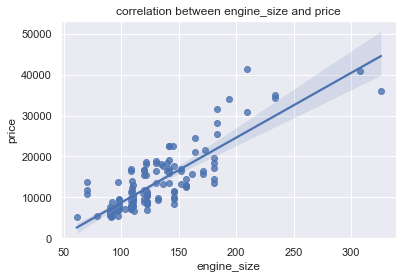

             engine_size     price
engine_size     1.000000  0.871051
price           0.871051  1.000000


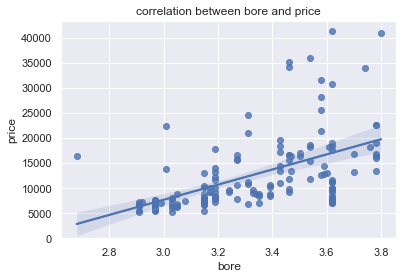

           bore     price
bore   1.000000  0.547582
price  0.547582  1.000000


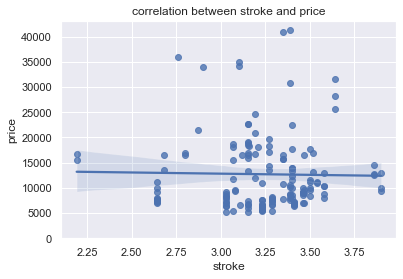

          stroke     price
stroke  1.000000  0.080014
price   0.080014  1.000000


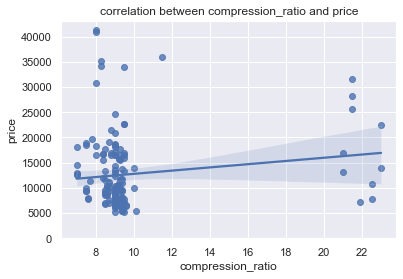

                   compression_ratio     price
compression_ratio           1.000000  0.069881
price                       0.069881  1.000000


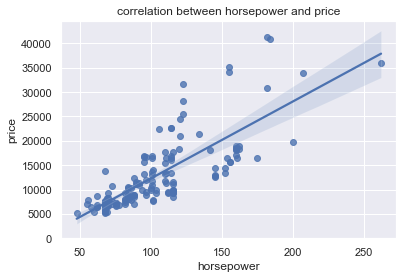

            horsepower     price
horsepower    1.000000  0.808366
price         0.808366  1.000000


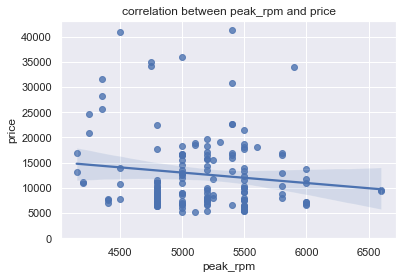

          peak_rpm     price
peak_rpm  1.000000 -0.097752
price    -0.097752  1.000000


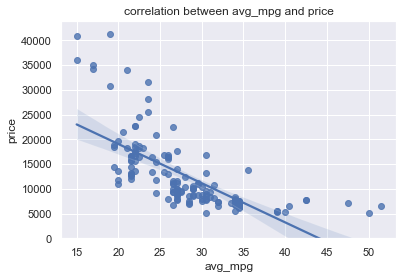

          avg_mpg     price
avg_mpg  1.000000 -0.702257
price   -0.702257  1.000000


In [84]:
x = df.select_dtypes(exclude=['object'])
for cols in x.columns.drop(['price']):
    plot_vis(cols)

Some of the highest correlated features include: `engine_size`, `curb_weight`, `horsepower`, `width` and `avg_mpg`.

2. Categorical variables

I'll split my inspection of categorical variables into two parts. For the first part, I will individually compare the relationship between a vehicle's manufacturer and its selling price. For the remaining categorical variables I will conduct one-factor ANOVA tests to determine fit.

Make of car vs. price:

<AxesSubplot:xlabel='make', ylabel='price'>

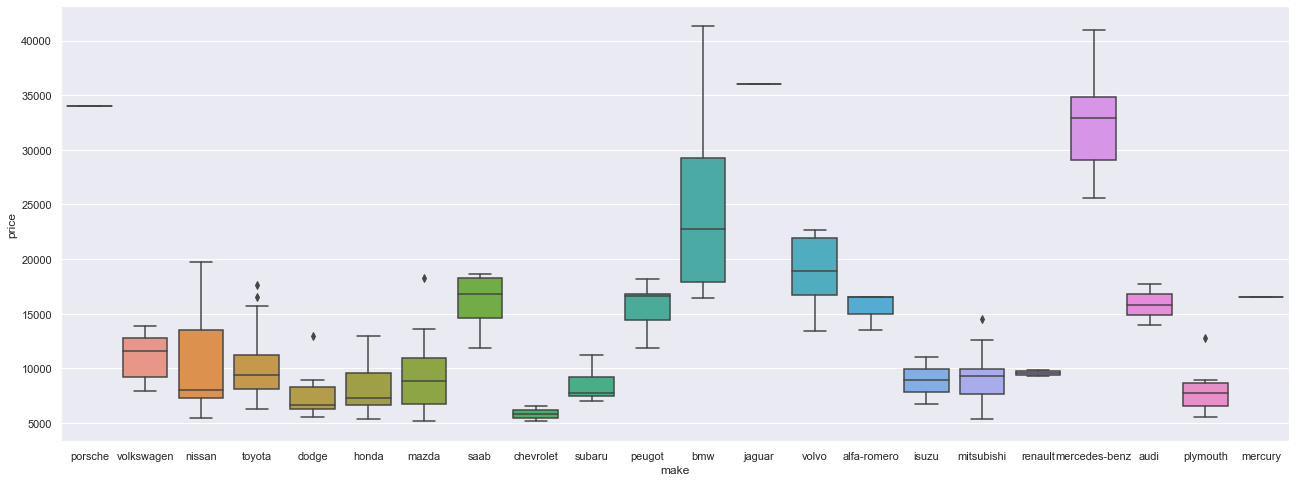

In [85]:
sns.set(rc = {'figure.figsize':(22,8)})
sns.boxplot(x = 'make', y = 'price', data = train)

Although we see differences between certain groups of manufacturers, most of the makes congregate very closely around a price range. This coupled with the fact that there are 22 unique categories for this variable means its fairly hard to use unless major modifications are made. For the sake of my sanity I give up.

ANOVA time baby!

In [86]:
import scipy.stats as stats

In [87]:
def anova_test(cat):
    cat_levels = train[cat].unique()
    F = stats.f_oneway(*(train['price'][train[cat] == level] for level in cat_levels))
    print('Category: '+ cat)
    print(F)

In [88]:
def plot_box(cat):    
    sns.set(rc = {'figure.figsize':(8,6)})
    sns.boxplot(x = cat, y = 'price', data = train)
    plt.ylim(0,)
    plt.title(cat +  ' vs price')
    plt.show()

Category: fuel_type
F_onewayResult(statistic=5.296361088502456, pvalue=0.02275623865899433)


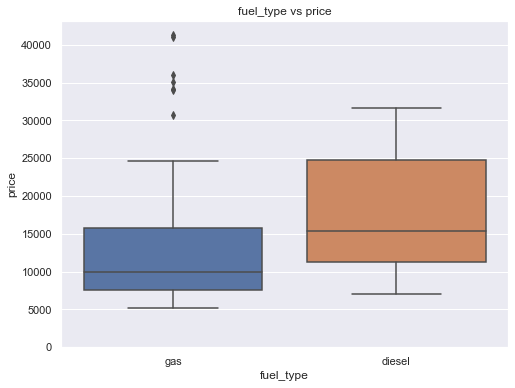

Category: aspiration
F_onewayResult(statistic=11.327949496159912, pvalue=0.0009712236113150695)


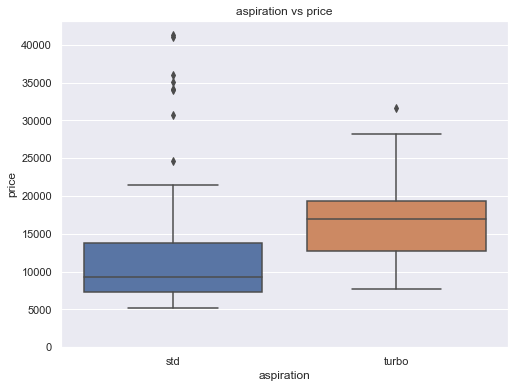

Category: num_of_doors
F_onewayResult(statistic=0.99873388838851, pvalue=0.31923727481223674)


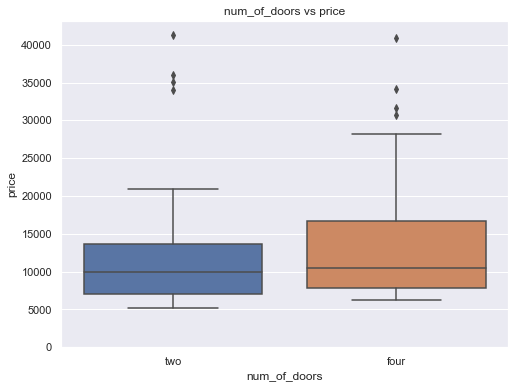

Category: body_style
F_onewayResult(statistic=4.475576826101201, pvalue=0.0019320060074232476)


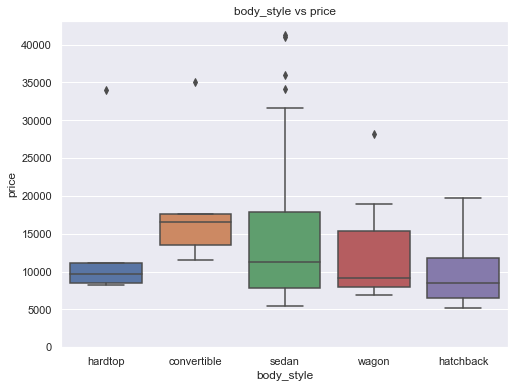

Category: drive_wheels
F_onewayResult(statistic=53.43181691424939, pvalue=3.4086663117967507e-18)


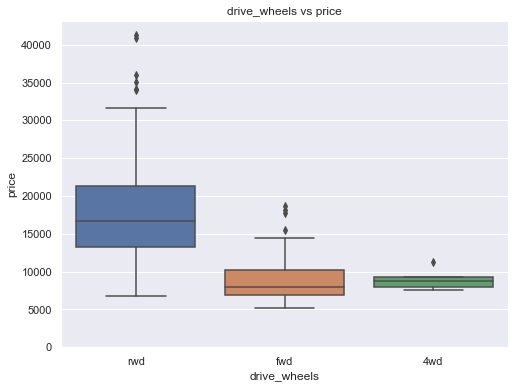

Category: engine_location
F_onewayResult(statistic=9.117199916895519, pvalue=0.002980046084701985)


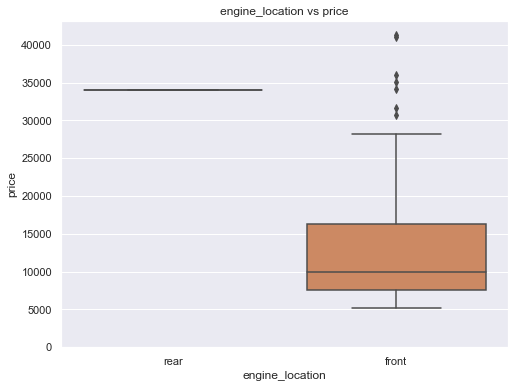

Category: engine_type
F_onewayResult(statistic=8.23024201732448, pvalue=7.23623195189535e-07)


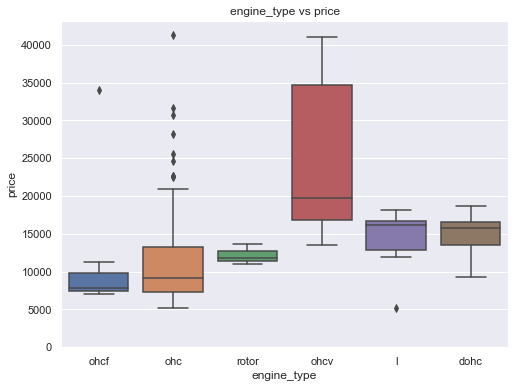

Category: num_cylinders
F_onewayResult(statistic=35.915601762772276, pvalue=2.439469259554299e-26)


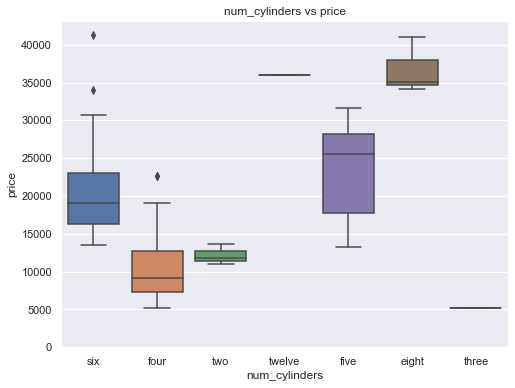

Category: fuel_system
F_onewayResult(statistic=14.362878465587865, pvalue=4.6552274049969456e-14)


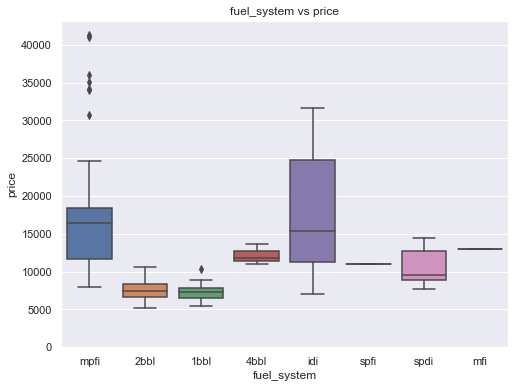

In [89]:
a = df.select_dtypes(include=['object'])
for cols in a.columns.drop(['make']):
    anova_test(cols)
    plot_box(cols)

The above ANOVA tests reveal that the categories most likely to have differences between category levels are: `num_cylinders`, `drive_wheels`, `fuel_system`, `engine_type` and `aspiration`.

From the above feature analysis, based on statistical test results I choose `engine_size`, `curb_weight`, `horsepower`, `num_cylinders`, `drive_wheels` and `fuel system` for my features to use in the model.

Part Trois: Developing models

Before different models can be trained, the categorical columns require preprocessing. Because the prices between different levels of `num_cylinders` and `drive_wheels` is very different, I will use an ordinal encoder. Similarly, since groups of levels in `fuel_system` show some overlap, I will use a one-hot encoder.

Using `OrdinalEncoder()` to transform `num_cylinders` and `drive_wheels`:

In [90]:
from sklearn.preprocessing import OrdinalEncoder

In [91]:
label_train_X = train_X[['engine_size','curb_weight','horsepower','num_cylinders','drive_wheels','fuel_system']]

In [92]:
ordinal_encoder = OrdinalEncoder()
label_train_X[['num_cylinders','drive_wheels']] = ordinal_encoder.fit_transform(label_train_X[['num_cylinders','drive_wheels']])

C:\Users\wwwia\AppData\Local\Temp/ipykernel_14820/3366111973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_train_X[['num_cylinders','drive_wheels']] = ordinal_encoder.fit_transform(label_train_X[['num_cylinders','drive_wheels']])


Using `pd.get_dummies()` to one-hot encode `fuel_system`:

In [93]:
def OH_encode(x):
    fuel_types = pd.get_dummies(x.fuel_system)
    x = x.drop('fuel_system', axis = 1)
    OH_x = pd.concat([x, fuel_types], axis = 1)
    return OH_x

In [94]:
train_X_touse = OH_encode(label_train_X)
train_X_touse.columns

Index(['engine_size', 'curb_weight', 'horsepower', 'num_cylinders',
       'drive_wheels', '1bbl', '2bbl', '4bbl', 'idi', 'mfi', 'mpfi', 'spdi',
       'spfi'],
      dtype='object')

Now the training dataset is ready to use!

In [95]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

For validating models:

In [96]:
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [97]:
def validate_model(model):
    cv = RepeatedKFold(n_splits=10, random_state=1)
    scores = -1 * cross_val_score(model, train_X_touse, train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    print('Mean Absolute Error: %.3f' % (mean(scores)))

I would like to compare the performance of various different models.

Starting with `RandomForestRegressor`：

In [98]:
model_1 = RandomForestRegressor(n_estimators = 200, random_state = 0)
validate_model(model_1)

Mean Absolute Error: 1604.377


Next, `XGBRegressor`:

In [99]:
model_2 = XGBRegressor(n_estimators = 200)
validate_model(model_2)

Mean Absolute Error: 1645.612


From the comparison of the above two models we can see the random forest model produced slightly better results. As such I will use it to train the model.

In [100]:
model_1.fit(train_X_touse, train_y)

RandomForestRegressor(n_estimators=200, random_state=0)

Part Quatre: Testing the model

Preprocessing the testing data:

In [101]:
label_test_X = test_X[['engine_size','curb_weight','horsepower','num_cylinders','drive_wheels','fuel_system']]
label_test_X[['num_cylinders','drive_wheels']] = ordinal_encoder.fit_transform(label_test_X[['num_cylinders','drive_wheels']])
test_X_touse = OH_encode(label_test_X)

C:\Users\wwwia\AppData\Local\Temp/ipykernel_14820/4255567000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_test_X[['num_cylinders','drive_wheels']] = ordinal_encoder.fit_transform(label_test_X[['num_cylinders','drive_wheels']])


In [102]:
test_X_touse.columns

Index(['engine_size', 'curb_weight', 'horsepower', 'num_cylinders',
       'drive_wheels', '1bbl', '2bbl', 'idi', 'mpfi', 'spdi'],
      dtype='object')

Because in the testing set we are missing columns `4bbl`, `mfi`and `spfi`, we must add them to the dataframe for the model to work:

In [103]:
test_X_touse.insert(loc = 7, column = '4bbl', value = 0)
test_X_touse.insert(loc = 9, column = 'mfi', value = 0)
test_X_touse.insert(loc = 12, column = 'spfi', value = 0)
test_X_touse.columns

Index(['engine_size', 'curb_weight', 'horsepower', 'num_cylinders',
       'drive_wheels', '1bbl', '2bbl', '4bbl', 'idi', 'mfi', 'mpfi', 'spdi',
       'spfi'],
      dtype='object')

In [104]:
preds_y = model_1.predict(test_X_touse)

Testing my predictions against the actual price:

In [105]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y, preds_y)

1869.7251638655464

The mean absolute error for the testing set was only slightly higher than the training set, nice!